In [23]:
import pandas as pd       # CSV and data handling
import numpy as np        # Number operations
import matplotlib.pyplot as plt   # Plotting
import seaborn as sns     # Graphical visualization
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
)
# Machine Learning models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
import warnings
warnings.filterwarnings('ignore')  # Error message suppress panna

In [24]:
# dataset path la irundhu read panrom
df = pd.read_csv('/kaggle/input/loan-risk-detector-1-1/Loan Risk Detector (1) 1.csv')
# first 5 rows paarpom
df.head()

,id,member_id,loan_amnt,funded_amnt,term,int_rate,installment,grade,sub_grade,emp_title,...,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,application_type,annual_inc_joint,dti_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim
0,60516983,64537751,20000,20000,36 months,12.29,667.06,C,C1,Accounting Clerk,...,Jan-16,0,NaN,INDIVIDUAL,NaN,NaN,0,0,52303,41000
1,60187139,64163931,11000,11000,36 months,12.69,369.00,C,C2,Accounts Payable Lead,...,Jan-16,0,79.0,INDIVIDUAL,NaN,NaN,0,332,175731,13100
2,60356453,64333218,7000,7000,36 months,9.99,225.84,B,B3,Nurse,...,Jan-16,0,NaN,INDIVIDUAL,NaN,NaN,0,0,202012,16300
3,59955769,63900496,10000,10000,36 months,10.99,327.34,B,B4,Service Manager,...,Jan-16,0,NaN,INDIVIDUAL,NaN,NaN,0,0,108235,34750
4,58703693,62544456,9550,9550,36 months,19.99,354.87,E,E4,NaN,...,Jan-16,0,69.0,INDIVIDUAL,NaN,NaN,0,0,45492,14100


In [25]:
print(df.columns.tolist())

['id', 'member_id', 'loan_amnt', 'funded_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'loan_status', 'purpose', 'title', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'inq_last_6mths', 'mths_since_last_delinq', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'out_prncp', 'total_pymnt', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'application_type', 'annual_inc_joint', 'dti_joint', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim']


In [26]:
# first namba Check type of int_rate
print(df['int_rate'].head())
print(df['int_rate'].dtype)  # check if it's string or float

# 2nd  If it's string, remove '%' and convert
if df['int_rate'].dtype == 'object':
    df['int_rate_clean'] = df['int_rate'].str.replace('%', '').astype(float)
else:
    df['int_rate_clean'] = df['int_rate']  # already float or clean

# eipo Fill NaN in dti
df['dti'] = df['dti'].fillna(0)

# derive the new column Create Loan_Risk column
df['Loan_Risk'] = ((df['int_rate_clean'] > 13) | (df['dti'] > 25)).astype(int)

# atlastla View result
df[['int_rate_clean', 'dti', 'Loan_Risk']].head()

0    12.29
1    12.69
2     9.99
3    10.99
4    19.99
Name: int_rate, dtype: float64
float64


,int_rate_clean,dti,Loan_Risk
0,12.29,20.72,0
1,12.69,24.57,0
2,9.99,32.41,1
3,10.99,30.98,1
4,19.99,32.54,1


In [27]:
# loan_amnt and funded_amnt difference etha solum full loan funded aana illaya?
df['fund_gap'] = df['loan_amnt'] - df['funded_amnt']
# Installment vs income ratio ethu solum customer kku pay panna strength iruka-nu paarpom
df['emi_to_income'] = df['installment'] / (df['annual_inc'] + 1)
# High income + coapplicant income combine panrom
df['total_inc'] = df['annual_inc'] + df['annual_inc_joint'].fillna(0)
# Loan amount to total income ratio
df['loan_to_income_ratio'] = df['loan_amnt'] / (df['total_inc'] + 1)
# Final features paarpom
df[['fund_gap', 'emi_to_income', 'total_inc', 'loan_to_income_ratio']].head()


,fund_gap,emi_to_income,total_inc,loan_to_income_ratio
0,0,0.010262,65000.0,0.307688
1,0,0.009225,40000.0,0.274993
2,0,0.007057,32000.0,0.218743
3,0,0.006819,48000.0,0.208329
4,0,0.010961,32376.0,0.294962


In [28]:
# Outlier check panna income and ratio columns use panrom
cols_to_check = ['annual_inc', 'loan_amnt', 'installment', 'emi_to_income', 'loan_to_income_ratio']

for col in cols_to_check:
    q99 = df[col].quantile(0.99)  # 99% k mela irukura value outlier-nu consider panrom
    df = df[df[col] <= q99]       # atha remove panrom

# Confirm panna shape print panrom
print("Cleaned dataset shape:", df.shape)


Cleaned dataset shape: (204664, 55)


In [29]:
from sklearn.preprocessing import LabelEncoder

# label encoder create panrom
le = LabelEncoder()

# categorical column detect panni encode panrom
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].fillna('Unknown')  # missing value handle
        df[col] = le.fit_transform(df[col])  # encode panrom

# result paarpom
df.head()


,id,member_id,loan_amnt,funded_amnt,term,int_rate,installment,grade,sub_grade,emp_title,...,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,int_rate_clean,Loan_Risk,fund_gap,emi_to_income,total_inc,loan_to_income_ratio
0,60516983,64537751,20000,20000,0,12.29,667.06,2,10,1383,...,0,0,52303,41000,12.29,0,0,0.010262,65000.0,0.307688
1,60187139,64163931,11000,11000,0,12.69,369.00,2,11,1515,...,0,332,175731,13100,12.69,0,0,0.009225,40000.0,0.274993
2,60356453,64333218,7000,7000,0,9.99,225.84,1,7,33887,...,0,0,202012,16300,9.99,1,0,0.007057,32000.0,0.218743
3,59955769,63900496,10000,10000,0,10.99,327.34,1,8,47707,...,0,0,108235,34750,10.99,1,0,0.006819,48000.0,0.208329
4,58703693,62544456,9550,9550,0,19.99,354.87,4,23,55429,...,0,0,45492,14100,19.99,1,0,0.010961,32376.0,0.294962


In [30]:
# Step 1: Drop leak columns first
leak_cols = [
    'loan_status', 'int_rate', 'dti', 'funded_amnt', 'out_prncp',
    'total_pymnt', 'total_rec_prncp', 'total_rec_int', 'recoveries',
    'collection_recovery_fee', 'last_pymnt_amnt', 'id', 'member_id',
    'url', 'emp_title', 'issue_d', 'title', 'last_pymnt_d',
    'next_pymnt_d', 'last_credit_pull_d', 'earliest_cr_line'
]
df.drop(columns=[col for col in leak_cols if col in df.columns], inplace=True)

# Step 2: Handle NaNs
df.fillna(df.median(numeric_only=True), inplace=True)

# Step 3: Define y and X
y = df['Loan_Risk']
X = df.drop(['Loan_Risk'], axis=1)

# Step 4: Scale X
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Step 5: Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)


In [31]:

# Result shape paarpom
print("X_train shape:", X_train.shape)
print("X_test shape :", X_test.shape)


X_train shape: (163731, 34)
X_test shape : (40933, 34)


In [32]:
#  Any remaining NaN ethu fill with median (safe for numeric columns)
df.fillna(df.median(numeric_only=True), inplace=True)

#  Recreate X and y since df changed
y = df['Loan_Risk']
X = df.drop(['Loan_Risk', 'id', 'member_id'], axis=1, errors='ignore')
#ethula drop paniduvom yen na ethula loan target and remaining athum value carry panala athan

# Scale again after fill
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X) #ethu la mean and standard deviation use pani ella oru scale la kondu varom
#  Re-split dataset
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, stratify=y, random_state=42
)



Logistic Regression
 Accuracy : 0.85
 Precision: 0.87
 Recall   : 0.84
 F1-Score : 0.85


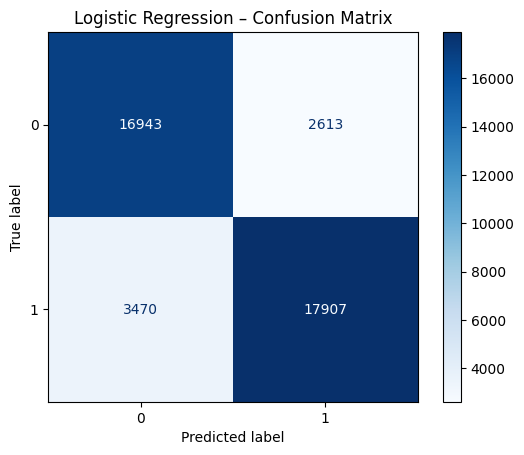

 AUC Score: 0.92


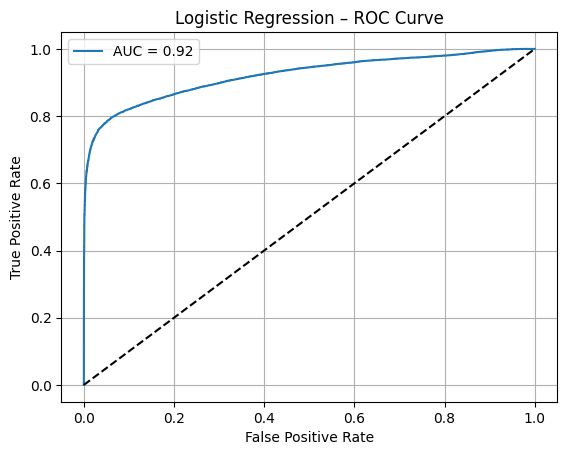


KNN
 Accuracy : 0.81
 Precision: 0.84
 Recall   : 0.79
 F1-Score : 0.81


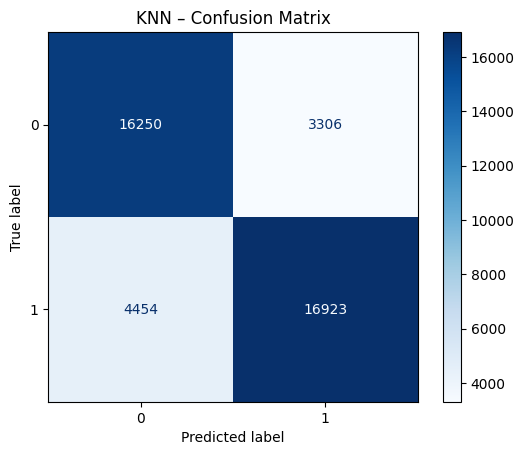

 AUC Score: 0.88


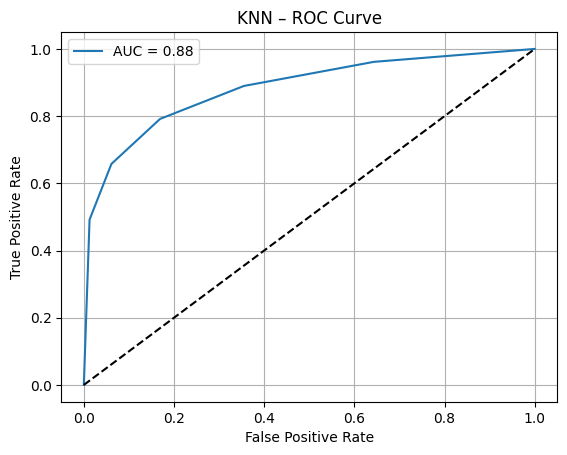


Naive Bayes
 Accuracy : 0.83
 Precision: 0.93
 Recall   : 0.73
 F1-Score : 0.82


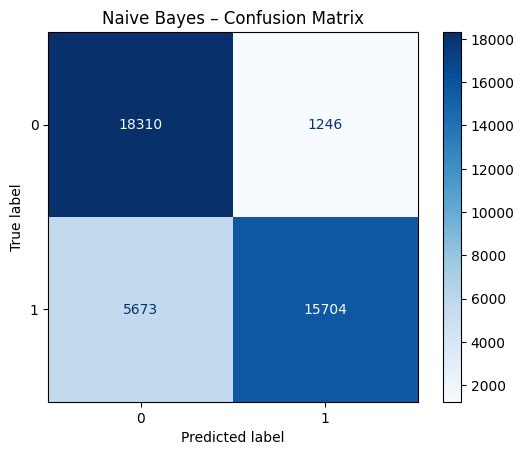

 AUC Score: 0.90


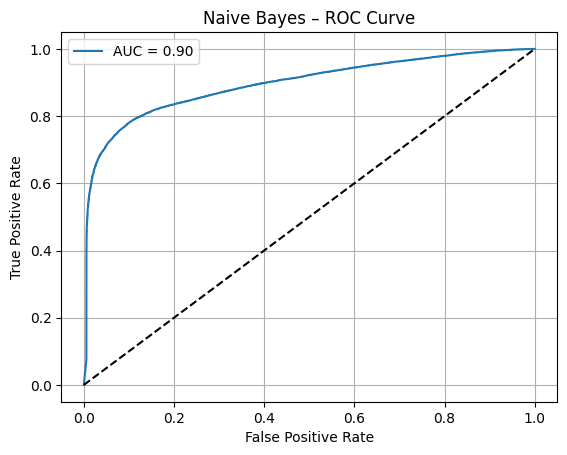


SVM
 Accuracy : 0.88
 Precision: 0.94
 Recall   : 0.82
 F1-Score : 0.87


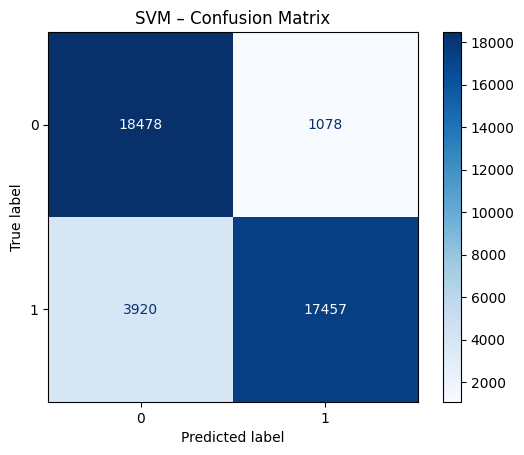

 AUC Score: 0.94


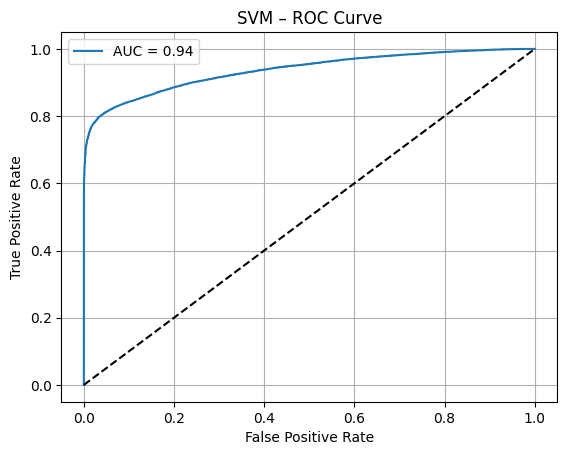


Random Forest
 Accuracy : 0.88
 Precision: 0.99
 Recall   : 0.78
 F1-Score : 0.87


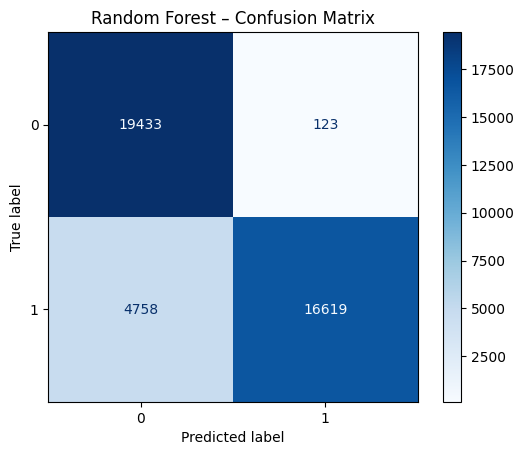

 AUC Score: 0.95


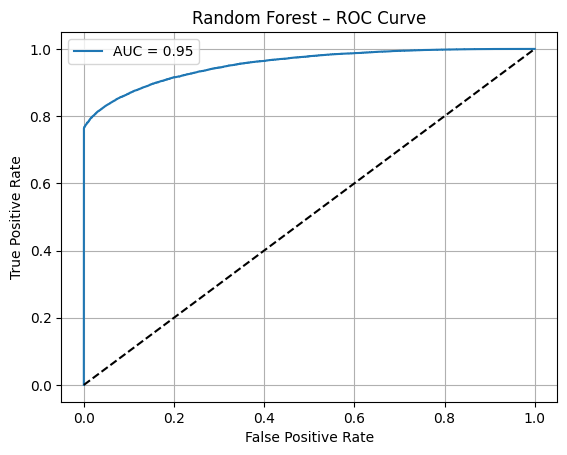


AdaBoost
 Accuracy : 0.88
 Precision: 1.00
 Recall   : 0.76
 F1-Score : 0.87


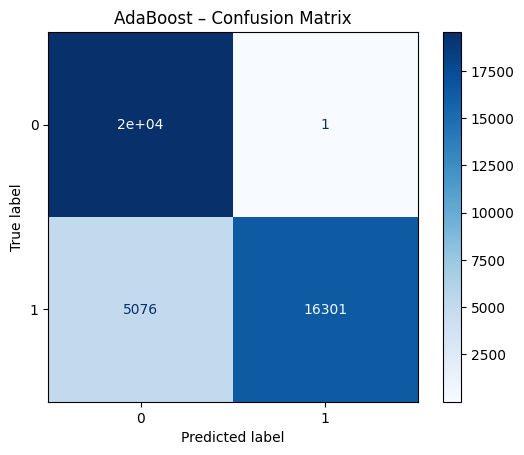

 AUC Score: 0.94


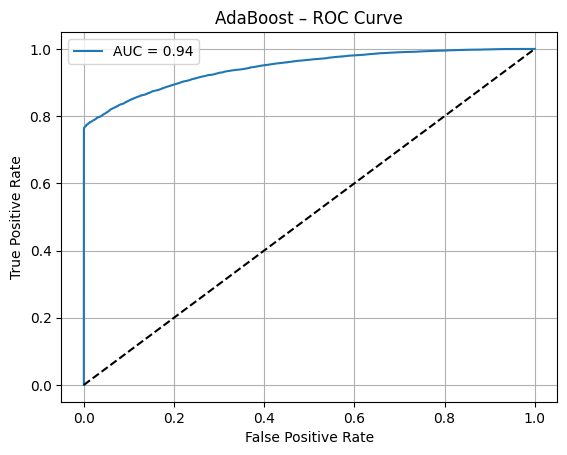


Gradient Boost
 Accuracy : 0.89
 Precision: 0.96
 Recall   : 0.82
 F1-Score : 0.88


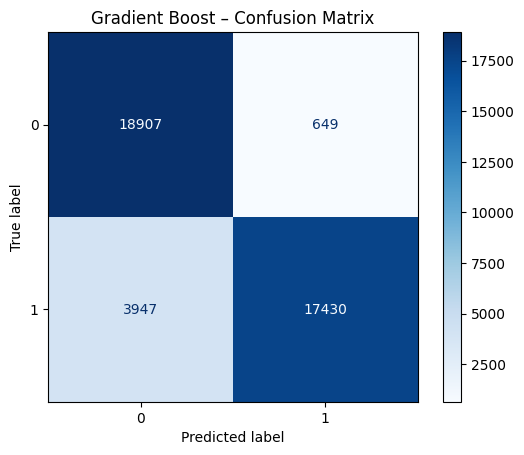

 AUC Score: 0.96


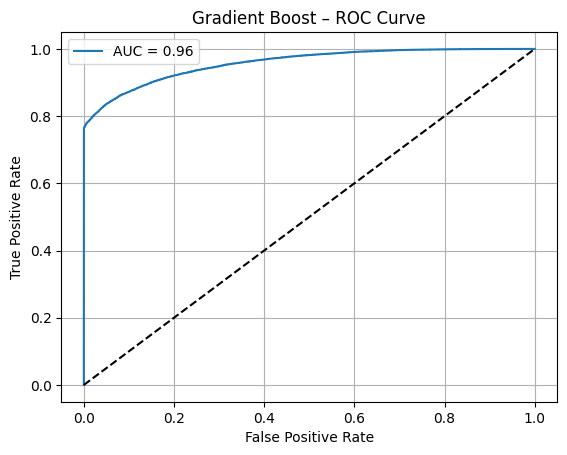

In [35]:
from sklearn.tree import DecisionTreeClassifier  # 🔁 Add this
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

# 🔧 Tuned parameters (dictionary format)
best_rf = {
    'max_depth': 10,
    'min_samples_leaf': 1,
    'min_samples_split': 2,
    'n_estimators': 50
}

best_ada = {
    'estimator': DecisionTreeClassifier(max_depth=1),
    'learning_rate': 0.1,
    'n_estimators': 50
}

best_gb = {
    'learning_rate': 0.1,
    'max_depth': 3,
    'n_estimators': 100,
    'subsample': 0.8
}

# ✅ All models instantiate pannrom with tuned params
models = {
    'Logistic Regression': LogisticRegression(),
    'KNN': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'SVM': SVC(probability=True),
    'Random Forest': RandomForestClassifier(**best_rf),
    'AdaBoost': AdaBoostClassifier(**best_ada),
    'Gradient Boost': GradientBoostingClassifier(**best_gb)
}

# 🔁 Evaluate all models
for name, model in models.items():
    model.fit(X_train, y_train)                     
    y_pred = model.predict(X_test)                   
    y_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"\n{name}")
    print(f" Accuracy : {acc:.2f}")
    print(f" Precision: {prec:.2f}")
    print(f" Recall   : {rec:.2f}")
    print(f" F1-Score : {f1:.2f}")

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(f"{name} – Confusion Matrix")
    plt.grid(False)
    plt.show()

    if y_proba is not None:
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)
        print(f" AUC Score: {roc_auc:.2f}")

        plt.figure()
        plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f"{name} – ROC Curve")
        plt.legend()
        plt.grid(True)
        plt.show()
    else:
        print(" ROC Curve not supported for this model.")
